# Chapter 7. Interactions

In [1]:
import itertools
import math

import pandas as pd
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats

from rethinking import LM, MAP, coef, compare, extract_samples, link, precis

### Code 7.1

In [2]:
rugged = pd.read_csv("../data/rugged.csv", sep=";")
d = rugged

# make log version of outcome
d["log_gdp"] = d["rgdppc_2000"].apply(math.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()]

# split countries into Africa and not-Africa
d_A1 = dd[dd["cont_africa"] == 1]  # Africa
d_A0 = dd[dd["cont_africa"] == 0]  # not Africa

### Code 7.2

In [3]:
# African nations
def model(rugged, log_gdp):
    a = pyro.sample("a", dist.Normal(8, 100))
    bR = pyro.sample("bR", dist.Normal(0, 1))
    mu = a + bR * rugged
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("log_gdp", dist.Normal(mu, sigma), obs=log_gdp)

d_A1.index = range(d_A1.shape[0])
d_A1_rugged = torch.tensor(d_A1["rugged"], dtype=torch.float)
d_A1_log_gdp = torch.tensor(d_A1["log_gdp"], dtype=torch.float)
m7_1 = MAP(model).run(d_A1_rugged, d_A1_log_gdp)

# non-African nations
def model(rugged, log_gdp):
    a = pyro.sample("a", dist.Normal(8, 100))
    bR = pyro.sample("bR", dist.Normal(0, 1))
    mu = a + bR * rugged
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("log_gdp", dist.Normal(mu, sigma), obs=log_gdp)

d_A0.index = range(d_A0.shape[0])
d_A0_rugged = torch.tensor(d_A0["rugged"], dtype=torch.float)
d_A0_log_gdp = torch.tensor(d_A0["log_gdp"], dtype=torch.float)
m7_2 = MAP(model).run(d_A0_rugged, d_A0_log_gdp)

### Code 7.3

In [4]:
def model(rugged, log_gdp):
    a = pyro.sample("a", dist.Normal(8, 100))
    bR = pyro.sample("bR", dist.Normal(0, 1))
    mu = a + bR * rugged
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("log_gdp", dist.Normal(mu, sigma), obs=log_gdp)

dd.index = range(dd.shape[0])
dd_rugged = torch.tensor(dd["rugged"], dtype=torch.float)
dd_log_gdp = torch.tensor(dd["log_gdp"], dtype=torch.float)
m7_3 = MAP(model).run(dd_rugged, dd_log_gdp)

### Code 7.4

In [5]:
def model(rugged, cont_africa, log_gdp):
    a = pyro.sample("a", dist.Normal(8, 100))
    bR = pyro.sample("bR", dist.Normal(0, 1))
    bA = pyro.sample("bA", dist.Normal(0, 1))
    mu = a + bR * rugged + bA * cont_africa
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("log_gdp", dist.Normal(mu, sigma), obs=log_gdp)

dd_cont_africa = torch.tensor(dd["cont_africa"], dtype=torch.float)
m7_4 = MAP(model).run(dd_rugged, dd_cont_africa, dd_log_gdp)

### Code 7.5

In [6]:
compare({"m7.3": m7_3, "m7.4": m7_4}).round(2)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
m7.4,476.36,4.39,0.00,1.0,15.26,0.00
m7.3,539.62,2.72,63.26,0.0,13.25,15.01


### Code 7.6

In [7]:
rugged_seq = torch.arange(start=-1, end=8, step=0.25)

# compute mu over samples, fixing cont_africa=0
mu_not_africa = link(m7_4, data={"cont_africa": 0, "rugged": rugged_seq})

# compute mu over samples, fixing cont_africa=1
mu_africa = link(m7_4, data={"cont_africa": 1, "rugged": rugged_seq})

# summarize to means and intervals
mu_not_africa_mean = mu_not_africa.mean(0)
mu_not_africa_PI = stats.pi(mu_not_africa, prob=0.97, dim=0)
mu_africa_mean = mu_africa.mean(0)
mu_africa_PI = stats.pi(mu_africa, prob=0.97, dim=0)

### Code 7.7

In [8]:
def model(rugged, cont_africa, log_gdp):
    a = pyro.sample("a", dist.Normal(8, 100))
    bR = pyro.sample("bR", dist.Normal(0, 1))
    bAR = pyro.sample("bAR", dist.Normal(0, 1))
    gamma = bR + bAR * cont_africa
    bA = pyro.sample("bA", dist.Normal(0, 1))
    mu = a + gamma * rugged + bA * cont_africa
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("log_gdp", dist.Normal(mu, sigma), obs=log_gdp)

m7_5 = MAP(model).run(dd_rugged, dd_cont_africa, dd_log_gdp)

### Code 7.8

In [9]:
compare({"m7.3": m7_3, "m7.4": m7_4, "m7.5": m7_5}).round(2)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
m7.5,469.44,5.20,0.00,0.97,15.01,0.00
m7.4,476.36,4.39,6.91,0.03,15.26,6.15
m7.3,539.62,2.72,70.18,0.00,13.25,15.08


### Code 7.9

In [10]:
def model(rugged, cont_africa, log_gdp):
    a = pyro.sample("a", dist.Normal(8, 100))
    bR = pyro.sample("bR", dist.Normal(0, 1))
    bA = pyro.sample("bA", dist.Normal(0, 1))
    bAR = pyro.sample("bAR", dist.Normal(0, 1))    
    mu = a + bR * rugged + bAR * rugged * cont_africa + bA * cont_africa
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("log_gdp", dist.Normal(mu, sigma), obs=log_gdp)

m7_5b = MAP(model).run(dd_rugged, dd_cont_africa, dd_log_gdp)

### Code 7.10

In [11]:
rugged_seq = torch.arange(start=-1, end=8.25, step=0.25)

mu_africa = link(m7_5, data={"cont_africa": 1, "rugged": rugged_seq})
mu_africa_mean = mu_africa.mean(0)
mu_africa_PI = stats.pi(mu_africa, prob=0.97, dim=0)

mu_not_africa = link(m7_5, data={"cont_africa": 0, "rugged": rugged_seq})
mu_not_africa_mean = mu_not_africa.mean(0)
mu_not_africa_PI = stats.pi(mu_not_africa, prob=0.97, dim=0)

### Code 7.11

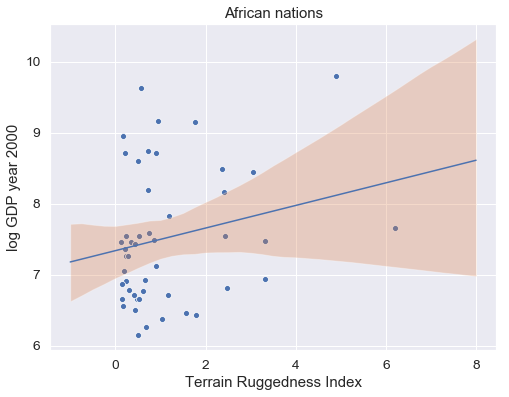

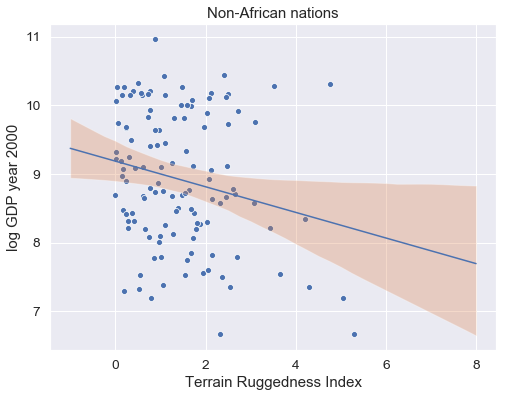

In [12]:
# plot African nations with regression
d_A1 = dd[dd["cont_africa"] == 1]
ax = sns.scatterplot("rugged", "log_gdp", data=d_A1)
ax.set(xlabel="Terrain Ruggedness Index", ylabel="log GDP year 2000",
       title="African nations")
sns.lineplot(rugged_seq, mu_africa_mean)
ax.fill_between(rugged_seq, mu_africa_PI[0], mu_africa_PI[1], alpha=0.3)
sns.mpl.pyplot.show()

# plot non-African nations with regression
d_A0 = dd[dd["cont_africa"] == 0]
ax = sns.scatterplot("rugged", "log_gdp", data=d_A0)
ax.set(xlabel="Terrain Ruggedness Index", ylabel="log GDP year 2000",
       title="Non-African nations")
sns.lineplot(rugged_seq, mu_not_africa_mean)
ax.fill_between(rugged_seq, mu_not_africa_PI[0], mu_not_africa_PI[1], alpha=0.3);

### Code 7.12

In [13]:
precis(m7_5)

,Mean,StdDev,|0.89,0.89|
a,9.19,0.14,8.98,9.41
bR,-0.19,0.08,-0.31,-0.07
bAR,0.35,0.13,0.15,0.55
bA,-1.85,0.22,-2.19,-1.49
sigma,0.94,0.05,0.86,1.02


### Code 7.13

In [14]:
post = extract_samples(m7_5)
gamma_africa = post["bR"] + post["bAR"] * 1
gamma_not_africa = post["bR"] + post["bAR"] * 0

### Code 7.14

In [15]:
print(gamma_africa.mean())
print(gamma_not_africa.mean())

tensor(0.1629)
tensor(-0.1858)


### Code 7.15

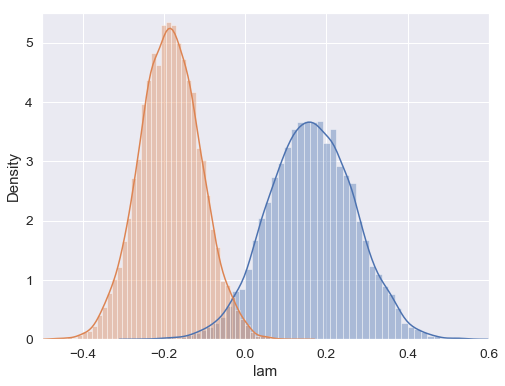

In [16]:
ax = sns.distplot(gamma_africa)
ax.set(xlabel="lam", ylabel="Density", xlim=(-0.5, 0.6), ylim=(0, 5.5))
sns.distplot(gamma_not_africa);

### Code 7.16

In [17]:
diff = gamma_africa - gamma_not_africa
(diff < 0).sum().float() / diff.size(0)

tensor(0.0038)

### Code 7.17

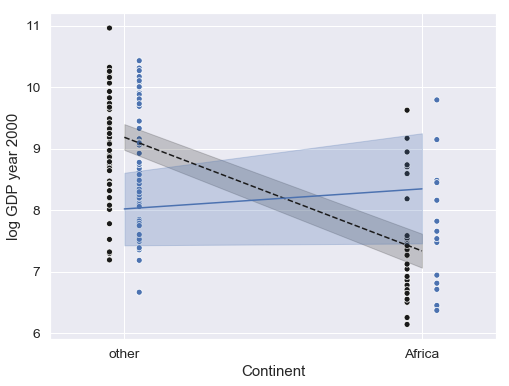

In [18]:
# get minimum and maximum rugged values
q_rugged = [dd_rugged.min(), dd_rugged.max()]

# compute lines and confidence intervals
mu_ruggedlo = link(m7_5, data={"rugged": q_rugged[0], "cont_africa": torch.arange(2.)})
mu_ruggedlo_mean = mu_ruggedlo.mean(0)
mu_ruggedlo_PI = stats.pi(mu_ruggedlo, 0.89, dim=0)

mu_ruggedhi = link(m7_5, data={"rugged": q_rugged[1], "cont_africa": torch.arange(2.)})
mu_ruggedhi_mean = mu_ruggedhi.mean(0)
mu_ruggedhi_PI = stats.pi(mu_ruggedhi, 0.89, dim=0)

# plot it all, splitting points at median
med_r = stats.quantile(dd_rugged, probs=0.5)
ox = torch.where(dd_rugged > med_r, torch.tensor(0.05), torch.tensor(-0.05))
ax = sns.scatterplot(dd_cont_africa + ox, dd["log_gdp"],
                     color=["b" if r > med_r else "k" for r in dd_rugged])
ax.set(xlabel="Continent", ylabel="log GDP year 2000", xlim=(-0.25, 1.25),
       xticks=[0, 1], xticklabels=['other', 'Africa'])
sns.lineplot([0, 1], mu_ruggedlo_mean, color="k")
ax.fill_between([0, 1], mu_ruggedlo_PI[0], mu_ruggedlo_PI[1], color="k", alpha=0.2)
ax.lines[0].set_linestyle("--")
sns.lineplot([0, 1], mu_ruggedhi_mean.tolist(), color="b")
ax.fill_between([0, 1], mu_ruggedhi_PI[0], mu_ruggedhi_PI[1], color="b", alpha=0.25);

### Code 7.16

In [19]:
tulips = pd.read_csv("../data/tulips.csv", sep=";")
d = tulips
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
bed       27 non-null object
water     27 non-null int64
shade     27 non-null int64
blooms    27 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 944.0+ bytes


,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


### Code 7.19

In [20]:
def model(water, shade, blooms):
    a = pyro.sample("a", dist.Normal(0, 100))
    bW = pyro.sample("bW", dist.Normal(0, 100))
    bS = pyro.sample("bS", dist.Normal(0, 100))
    mu = a + bW * water + bS * shade
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    with pyro.plate("plate"):
        pyro.sample("blooms", dist.Normal(mu, sigma), obs=blooms)

water = torch.tensor(d["water"], dtype=torch.float)
shade = torch.tensor(d["shade"], dtype=torch.float)
blooms = torch.tensor(d["blooms"], dtype=torch.float)
m7_6 = MAP(model).run(water, shade, blooms)

def model(water, shade, blooms):
    a = pyro.sample("a", dist.Normal(0, 100))
    bW = pyro.sample("bW", dist.Normal(0, 100))
    bS = pyro.sample("bS", dist.Normal(0, 100))
    bWS = pyro.sample("bWS", dist.Normal(0, 100))
    mu = a + bW * water + bS * shade + bWS * water * shade
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    with pyro.plate("plate"):
        pyro.sample("blooms", dist.Normal(mu, sigma), obs=blooms)

m7_7 = MAP(model).run(water, shade, blooms)

### Code 7.20

In [21]:
def model(water, shade, blooms):
    a = pyro.sample("a", dist.Normal(0, 100))
    bW = pyro.sample("bW", dist.Normal(0, 100))
    bS = pyro.sample("bS", dist.Normal(0, 100))
    mu = a + bW * water + bS * shade
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    with pyro.plate("plate"):
        pyro.sample("blooms", dist.Normal(mu, sigma), obs=blooms)

m7_6 = MAP(model).run(water, shade, blooms)

def model(water, shade, blooms):
    a = pyro.sample("a", dist.Normal(0, 100))
    bW = pyro.sample("bW", dist.Normal(0, 100))
    bS = pyro.sample("bS", dist.Normal(0, 100))
    bWS = pyro.sample("bWS", dist.Normal(0, 100))
    mu = a + bW * water + bS * shade + bWS * water * shade
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    with pyro.plate("plate"):
        pyro.sample("blooms", dist.Normal(mu, sigma), obs=blooms)

m7_7 = MAP(model).run(water, shade, blooms)

### Code 7.21

In [22]:
pd.concat([precis(m7_6), precis(m7_7)], keys=["m7.6", "m7.7"]).unstack(level=0)["Mean"]

,m7.6,m7.7
a,53.39,-83.49
bS,-38.92,34.58
bW,76.45,150.77
bWS,NaN,-39.36
sigma,56.91,46.38


### Code 7.22

In [23]:
compare({"m7.6": m7_6, "m7.7": m7_7}).round(2)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
m7.7,295.93,5.99,0.00,0.99,9.86,0.0
m7.6,305.75,5.26,9.82,0.01,9.21,5.8


### Code 7.23

In [24]:
d["shade.c"] = d["shade"] - d["shade"].mean()
d["water.c"] = d["water"] - d["water"].mean()

### Code 7.24

In [25]:
def model(water, shade, blooms):
    a = pyro.sample("a", dist.Normal(130, 100))
    bW = pyro.sample("bW", dist.Normal(0, 100))
    bS = pyro.sample("bS", dist.Normal(0, 100))
    mu = a + bW * water + bS * shade
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    with pyro.plate("plate"):
        pyro.sample("blooms", dist.Normal(mu, sigma), obs=blooms)

m7_8 = MAP(model, start={"a": blooms.mean(), "bW": torch.tensor(0.),
                         "bS": torch.tensor(0.)})
water_c = torch.tensor(d["water.c"], dtype=torch.float)
shade_c = torch.tensor(d["shade.c"], dtype=torch.float)
m7_8.run(water_c, shade_c, blooms)

def model(water, shade, blooms):
    a = pyro.sample("a", dist.Normal(130, 100))
    bW = pyro.sample("bW", dist.Normal(0, 100))
    bS = pyro.sample("bS", dist.Normal(0, 100))
    bWS = pyro.sample("bWS", dist.Normal(0, 100))
    mu = a + bW * water + bS * shade + bWS * water * shade
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    with pyro.plate("plate"):
        pyro.sample("blooms", dist.Normal(mu, sigma), obs=blooms)

m7_9 = MAP(model, start={"a": blooms.mean(), "bW": torch.tensor(0.),
                         "bS": torch.tensor(0.)})
m7_9.run(water_c, shade_c, blooms)
pd.concat([precis(m7_8), precis(m7_9)], keys=["m7.8", "m7.9"]).unstack(level=0)["Mean"]

,m7.8,m7.9
a,128.99,129.08
bS,-41.08,-41.30
bW,74.46,74.83
bWS,NaN,-52.23
sigma,56.80,45.61


### Code 7.25

In [26]:
k = list(coef(m7_7).values())
k[0] + k[1] * 2 + k[2] * 2 + k[3] * 2 * 2

tensor(129.7896)

### Code 7.26

In [27]:
k = list(coef(m7_9).values())
k[0] + k[1] * 0 + k[2] * 0 + k[3] * 0 * 0

tensor(129.0843)

### Code 7.27

In [28]:
precis(m7_9)

,Mean,StdDev,|0.89,0.89|
a,129.08,8.82,115.15,143.15
bW,74.83,10.70,56.77,90.90
bS,-41.30,10.52,-57.35,-24.30
bWS,-52.23,13.08,-71.76,-30.03
sigma,45.61,6.04,36.21,55.56


### Code 7.28

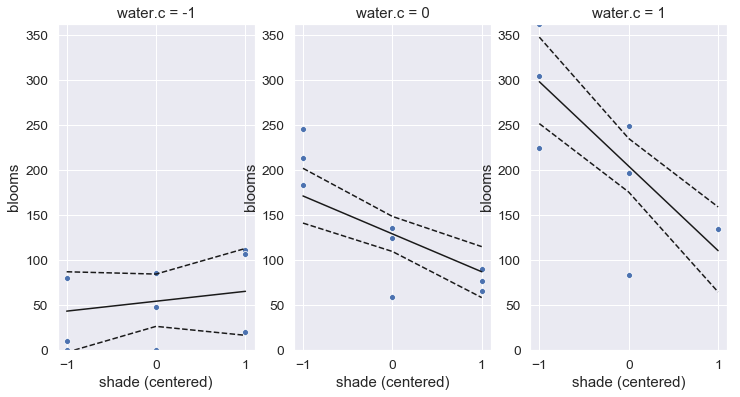

In [29]:
# make a plot window with three panels in a single row
_, axes = sns.mpl.pyplot.subplots(1, 3, figsize=(12, 6))  # 1 row, 3 columns

# loop over values of water.c and plot predictions
shade_seq = torch.arange(-1., 2)
for i, w in enumerate(range(-1, 2)):
    dt = d[d["water.c"] == w]
    sns.scatterplot("shade.c", "blooms", data=dt, ax=axes[i])
    axes[i].set(xlabel="shade (centered)", ylabel="blooms", xticks=range(-1, 2),
                title="water.c = {}".format(w), ylim=(0, 362))
    mu = link(m7_9, data={"water": w, "shade": shade_seq})
    mu_mean = mu.mean(0)
    mu_PI = stats.pi(mu, prob=0.97, dim=0)
    sns.lineplot(shade_seq, mu_mean, ax=axes[i], color="k")
    sns.lineplot(shade_seq, mu_PI[0], ax=axes[i], color="k")
    axes[i].lines[-1].set_linestyle("--")
    sns.lineplot(shade_seq, mu_PI[1], ax=axes[i], color="k")
    axes[i].lines[-1].set_linestyle("--")

### Code 7.29

```python
m7_x = LM("y ~ x + z + I(x * z)", data=d)
```

### Code 7.30

```python
m7_x = LM("y ~ x + z + I(x * z)", data=d)
```

### Code 7.31

```python
m7_x = LM("y ~ x + I(x * z)", data=d)
```

### Code 7.32

```python
m7_x = LM("y ~ x + z + w + I(x * z) + I(x * w) + I(z * w) + I(x * z * w)", data=d)
```

### Code 7.33

In [30]:
x = z = w = 1
["Intercept"] + [" * ".join(c) for i in range(1, 4)
                 for c in itertools.combinations("xzw", i)]

['Intercept', 'x', 'z', 'w', 'x * z', 'x * w', 'z * w', 'x * z * w']

### Code 7.34

In [31]:
nettle = pd.read_csv("../data/nettle.csv", sep=";")
d = nettle
d["lang.per.cap"] = d["num.lang"] / d["k.pop"]